# STEP 1: Import all necessary libraries
Organized imports logically, grouping standard library imports, third-party library imports, and TensorFlow-related imports separately.

In [23]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Suppress warnings (Optional), to reduce noise during the run.
import warnings
warnings.filterwarnings("ignore")

# STEP 2: EDA - Load & Unzip the Dataset & Display Sample Images

<b>`zipfile.ZipFil()`</b> :
    - Used to extract files from a zip archive.

<b>`zip_ref`</b> :
    - Used to reference the zip file during extraction.

<b>`zip_ref.extractall()`</b> :
    - Used to extract all files from a zip archive, simplifying the process of working with compressed files.


In [2]:
# Paths to the zip files
FACE_EXPRESSION_ZIP = "C:/Users/girli/EC_Utbildning/Deep_Learning_Kunskapskontroll_2/Face_expression_recognition_dataset.zip"

# Unzip the dataset 
with zipfile.ZipFile(FACE_EXPRESSION_ZIP, 'r') as zip_ref:
    zip_ref.extractall("Face_expression_recognition_dataset")

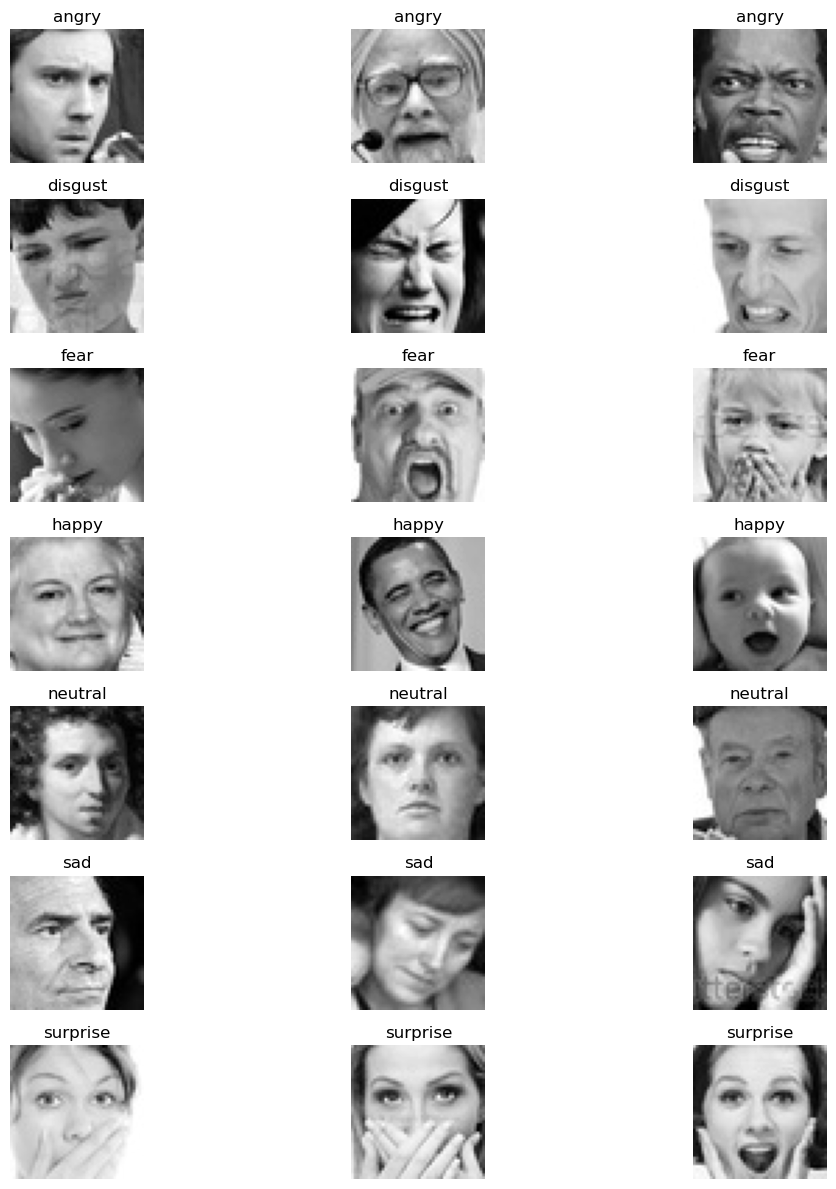

In [3]:
# Path to the unzipped dataset
FACE_EXP_FOLDER_PATH = "Face_expression_recognition_dataset/images/"
PICTURE_SIZE = 48

# Displaying sample images from the face expression dataset
expression_categories = os.listdir(os.path.join(FACE_EXP_FOLDER_PATH, "train"))

plt.figure(figsize=(12, 12))
for i, expression in enumerate(expression_categories):
    expression_folder_path = os.path.join(FACE_EXP_FOLDER_PATH, "train", expression)
    for j in range(3):  # Display 3 images per category
        img_path = os.path.join(expression_folder_path, os.listdir(expression_folder_path)[j])
        img = load_img(img_path, target_size=(PICTURE_SIZE, PICTURE_SIZE), color_mode='grayscale')
        plt.subplot(len(expression_categories), 3, i * 3 + j + 1)
        plt.imshow(img, cmap='gray')
        plt.title(expression)
        plt.axis('off')
plt.tight_layout()
plt.show()


# STEP 3: Data Preprocessing & Augmentation
Preprocessing and augmentation enhance model robustness by standardizing input data and increasing dataset diversity, improving generalization and performance.

<b>`ImageDataGenerator()`</b> :
    - Used for real-time data augmentation, which enhances model generalization and robustness by generating varied training examples 
      from existing data.

<b>`rescale=1. / 255`</b> :
    - Scales pixel values to the range [0,1], aiding convergence during training.
    
<b>`rotation_range=20`</b> :
    - Introduces random rotations of up to 20 degrees during data augmentation, enhancing model robustness to variations in input images.

<b>`width_shift_range=0.2`</b> :
    - Randomly shift the width of images during data augmentation, increasing model robustness to variations in object position.
    
<b>`height_shift_range=0.2`</b> :
    - Introduce vertical shifts of up to 20% of the image height, enhancing robustness against positional variations in the dataset.
    
<b>`shear_range=0.2`</b> :
    - Introduce shearing transformations in data augmentation, enhancing model robustness to variations in input images.
    
<b>`zoom_range=0.2`</b> :
    - To apply random zoom augmentation during training, increasing model robustness to variations in input size.

<b>`horizontal_flip=True`</b> :
    - To augment the dataset by horizontally flipping images, increasing variability and robustness of the model.

<b>`fill_mode='nearest'`</b> :
    - Used to fill in missing pixels during data augmentation by replicating the nearest existing pixel value.

<b>` datagen_train.flow_from_directory`</b> :
    - Simplifies the process of loading and augmenting image data from directories, streamlining training.

<b>`os.path.join(FACE_EXP_FOLDER_PATH, "train")`</b> :
    - Combines path components, ensuring compatibility across different operating systems.

<b>`target_size=(PICTURE_SIZE, PICTURE_SIZE)`</b> :
    - Used to resize images to a specific size, ensuring uniformity in input dimensions for the model.

<b>`color_mode="grayscale"`</b> :
    - Ensures that the images are loaded in grayscale mode, reducing computational complexity by eliminating unnecessary color channels.

<b>`batch_size=128`</b> :
    - Allows for efficient training by processing multiple samples simultaneously, optimizing GPU memory usage.

<b>`class_mode='categorical'`</b> :
    - To handle multi-class classification tasks where each image belongs to one of several predefined classes.

<b>`shuffle=True`</b> :
    - Randomizes the order of training samples, preventing the model from learning the sequence and improving generalization.

In [4]:
datagen_train = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1. / 255)

train_set = datagen_train.flow_from_directory(
    os.path.join(FACE_EXP_FOLDER_PATH, "train"),
    target_size=(PICTURE_SIZE, PICTURE_SIZE),
    color_mode="grayscale",
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

val_set = datagen_val.flow_from_directory(
    os.path.join(FACE_EXP_FOLDER_PATH, "validation"),
    target_size=(PICTURE_SIZE, PICTURE_SIZE),
    color_mode="grayscale",
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# STEP 4: Define Model Architecture
Built a Sequential model with multiple convolutional layers followed by batch normalization, ReLU activation, max-pooling, and dropout layers.

<b>`Sequential()`</b> : 
    - Simple, easy to implement model, and suitable for straightforward layer stacks.

<b>`model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))`</b> : 
    - Extracts features with 64 filters of size 3x3, maintains input dimensions (48x48 grayscale), and preserves spatial size using 'same' padding.

<b>`model.add(BatchNormalization())`</b> :
    - Normalize data within each mini-batch, enhancing training speed and stability.

<b>`model.add(Activation('relu'))`</b> : 
    - Introduce non-linearity, enabling the model to learn complex patterns.

<b>`model.add(MaxPooling2D(pool_size=(2, 2))) `</b> : 
    - Reduce spatial dimensions and computational load while retaining important features.

<b>`model.add(Dropout(0.25))`</b> : 
    - Prevent overfitting by randomly dropping 25% of neurons during training.

<b>`model.add(Flatten())`</b> : 
    - Convert the 2D matrix to a 1D vector for the fully connected layers.

<b>`model.add(Dense(512))`</b> : 
    - Used to add a fully connected layer with 512 neurons for learning complex patterns.

<b>`model.add(Dense(NO_OF_CLASSES, activation='softmax'))`</b> : 
    - To output probabilities across classes.

<b>`opt = Adam(learning_rate=0.0001)`</b> : 
    - Optimize the model's learning process with a specific learning rate.

<b>`model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])`</b> : 
    - To configure the model for training by specifying the optimizer, loss function, and evaluation metric, ensuring efficient training and 
      performance evaluation.

<b>`model.summary()`</b> : 
    - Provides a concise overview of the network architecture and parameter counts, aiding in model understanding and debugging.

In [5]:
NO_OF_CLASSES = 7

model = Sequential() 

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1))) 
model.add(BatchNormalization()) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 

model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(NO_OF_CLASSES, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4608)           │        18,432 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,544,455 (21.15 MB)

 Trainable params: 5,531,783 (21.10 MB)

 Non-trainable params: 12,672 (49.50 KB)

In [6]:
# Callbacks:
# Used `EarlyStopping` to stop training when the validation loss stops improving, restoring the best model weights.
# Used `ModelCheckpoint` to save the best model based on validation accuracy.
# Used `ReduceLROnPlateau` to reduce the learning rate when the validation loss plateaus, helping the model to converge better.

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True),
    ModelCheckpoint("model_expression.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_delta=0.0001)
]

# STEP 5: Train Model
Train the model using the training and validation data generators, with a specified number of epochs and steps per epoch.

In [7]:
# Monitor and Optimize the Model
history = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=150,
    validation_data=val_set,
    validation_steps=val_set.n // val_set.batch_size,
    callbacks=callbacks
)

Epoch 1/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1900 - loss: 2.1845
Epoch 1: val_accuracy improved from -inf to 0.26151, saving model to model_expression.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.1901 - loss: 2.1840 - val_accuracy: 0.2615 - val_loss: 1.8577 - learning_rate: 1.0000e-04
Epoch 2/150
  1/225 ━━━━━━━━━━━━━━━━━━━━ 4:00 1s/step - accuracy: 0.1953 - loss: 1.9407
Epoch 2: val_accuracy did not improve from 0.26151
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.1953 - loss: 1.9407 - val_accuracy: 0.0000e+00 - val_loss: 3.0534 - learning_rate: 1.0000e-04
Epoch 3/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2309 - loss: 1.9633
Epoch 3: val_accuracy did not improve from 0.26151
225/225 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.2309 - loss: 1.9632 - val_accuracy: 0.1977 - val_loss: 1.8271 - learning_rate: 1.0000e-04
Epoch 4/150
  1/225 ━━━━━━━━━━━━━━━━━━━━ 4:09 1s/step - accuracy: 0.2422 - loss: 1.8668
Epoch 4: val_ac

# STEP 6: Plot the Accuracy & Loss results

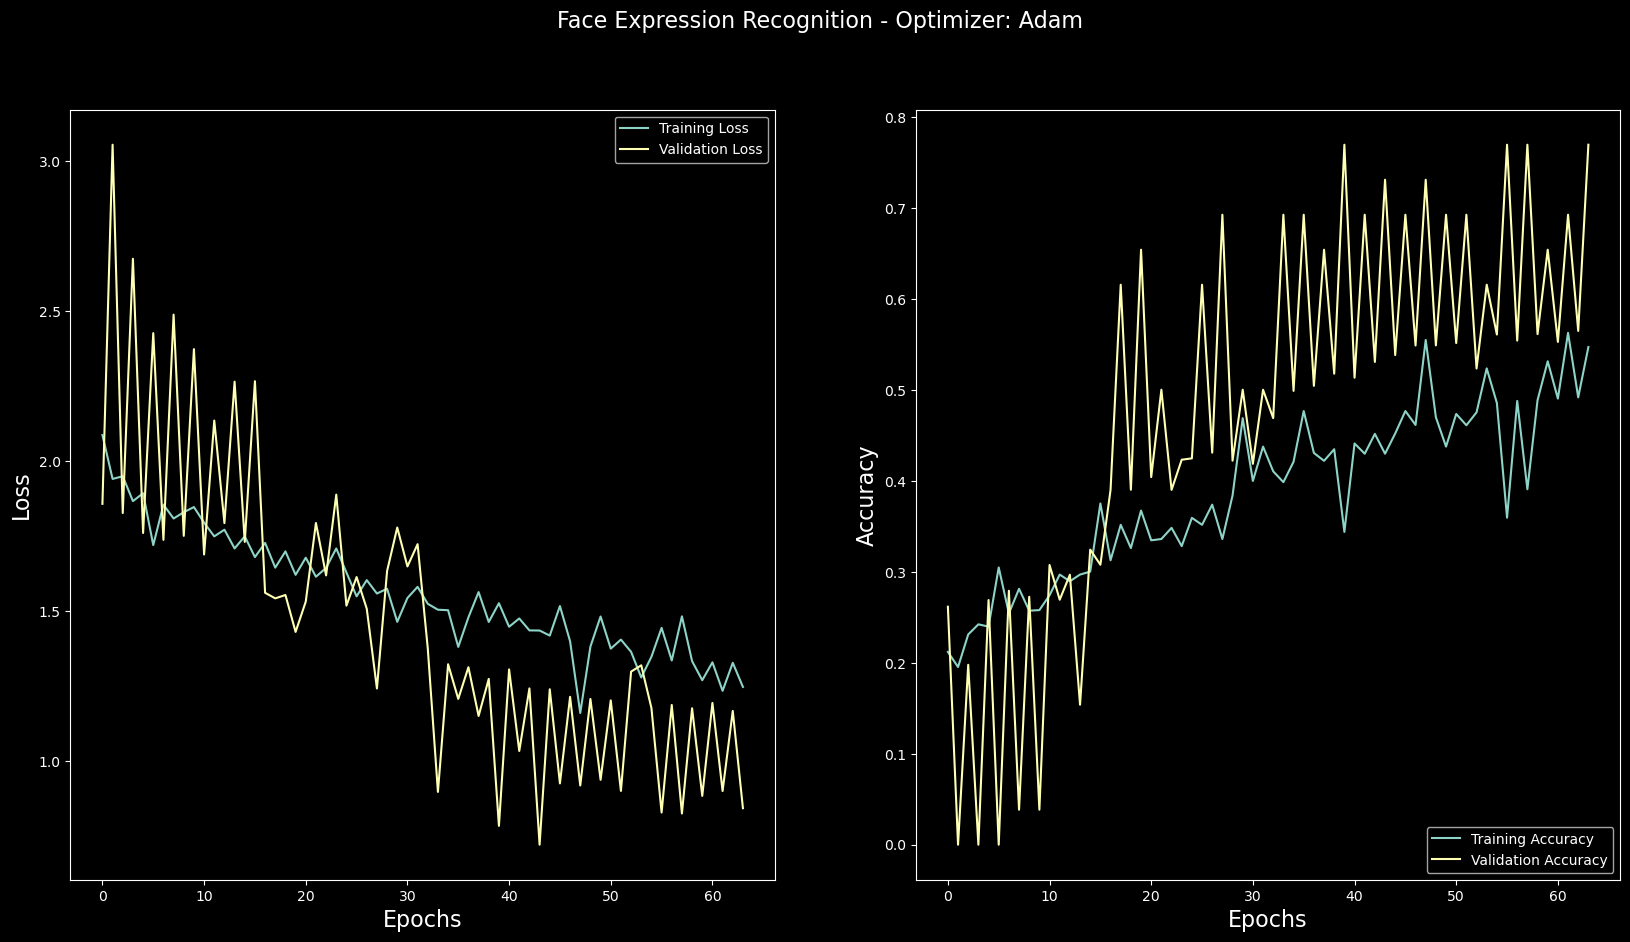

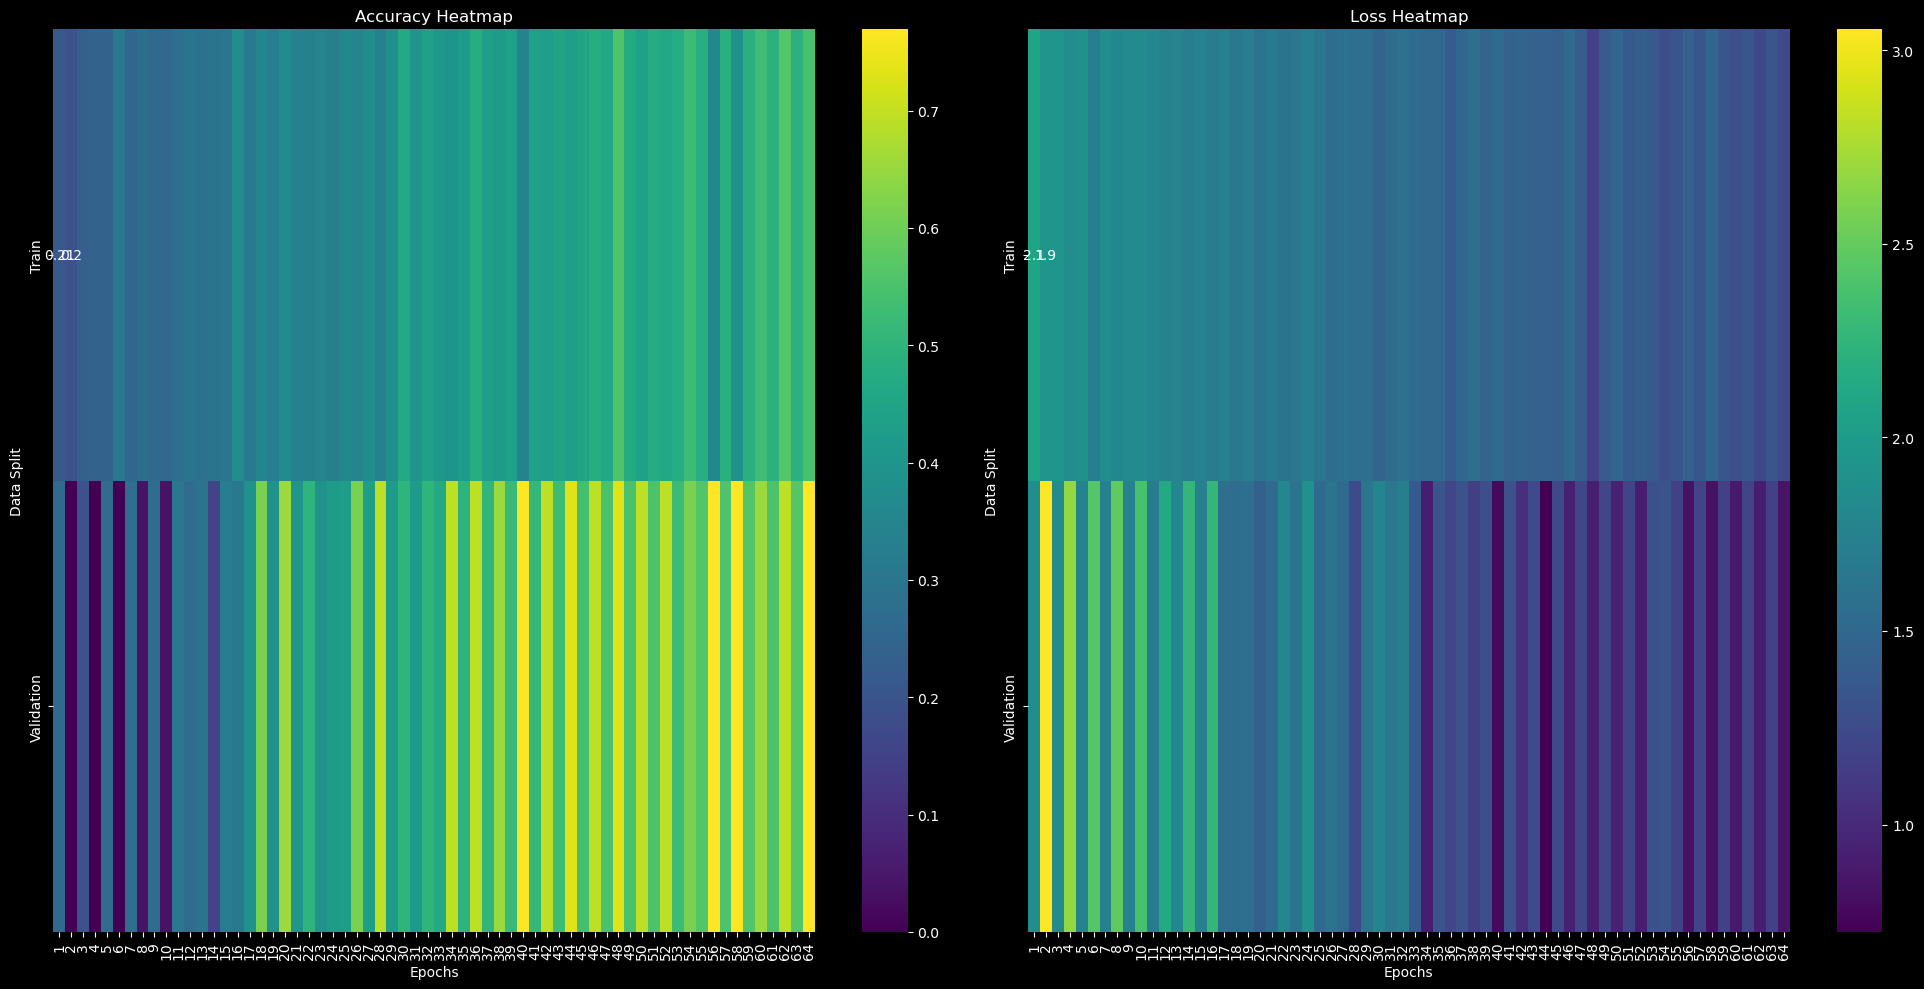

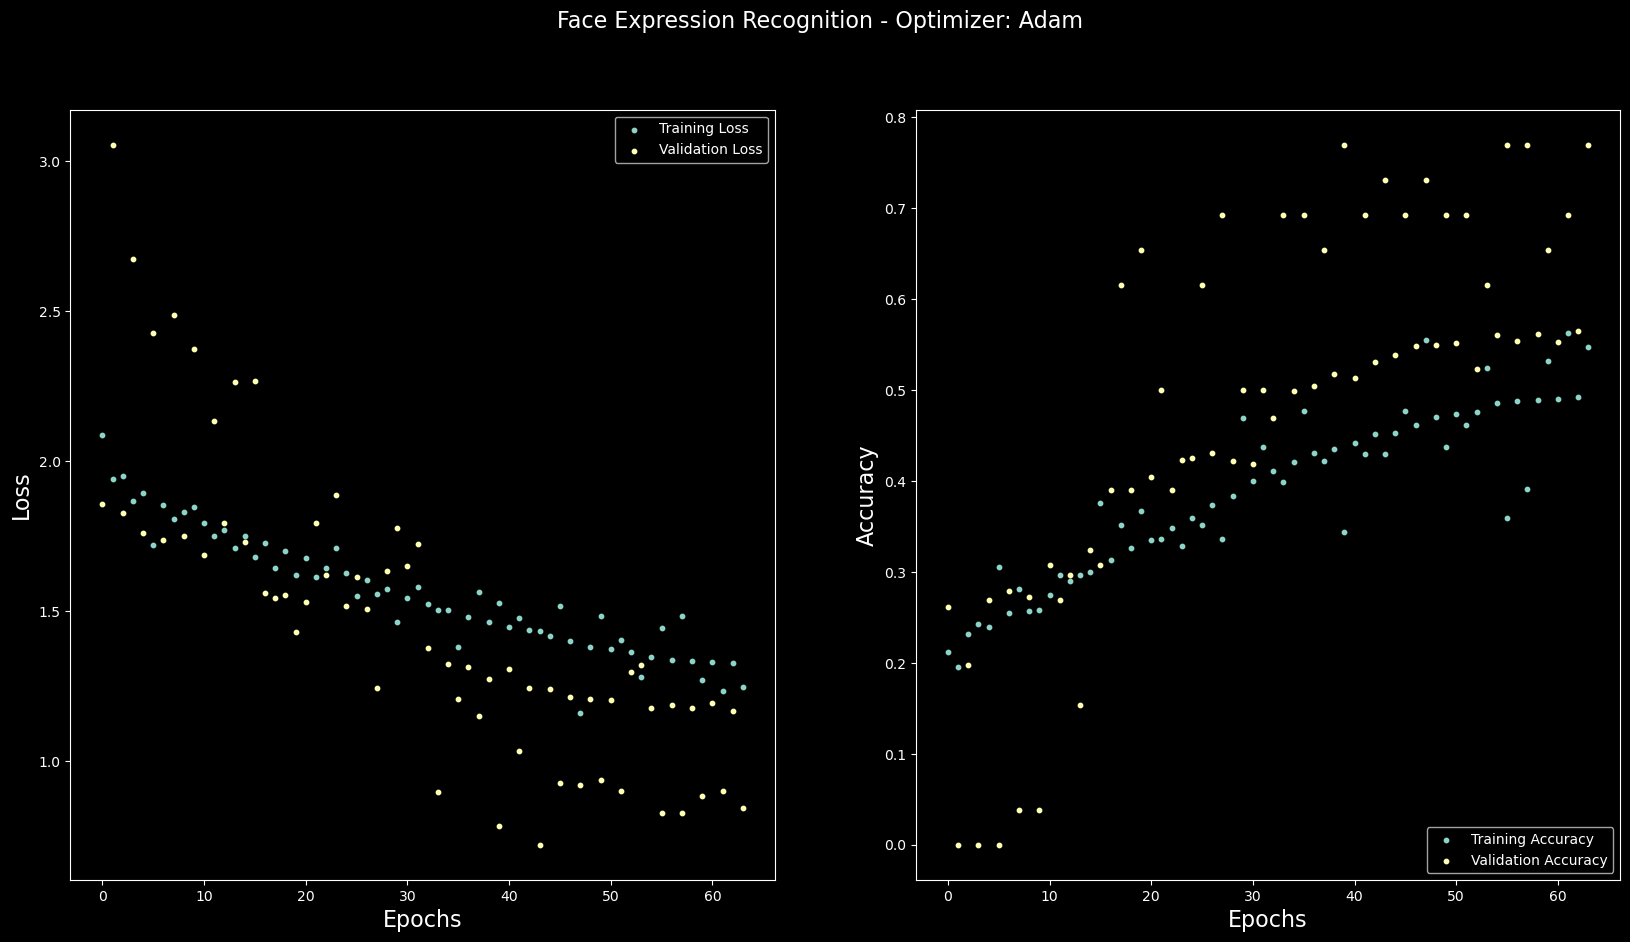

In [25]:
# Plot Results
plt.style.use('dark_background')
plt.figure(figsize=(20, 10))

# Plot loss
plt.subplot(1, 2, 1)
plt.suptitle('Face Expression Recognition - Optimizer: Adam', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

# Plotting heatmaps
def plot_heatmap(history, metric, title):
    epochs = range(1, len(history.history[metric]) + 1)
    data = np.array([history.history[metric], history.history[f'val_{metric}']])
    sns.heatmap(data, annot=True, xticklabels=epochs, yticklabels=['Train', 'Validation'], cmap='viridis')
    plt.xlabel('Epochs')
    plt.ylabel('Data Split')
    plt.title(title)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plot_heatmap(history, 'accuracy', 'Accuracy Heatmap')

plt.subplot(1, 2, 2)
plot_heatmap(history, 'loss', 'Loss Heatmap')

plt.tight_layout()
plt.show()


# Plot Results
plt.style.use('dark_background')
plt.figure(figsize=(20, 10))

# Plot loss
plt.subplot(1, 2, 1)
plt.suptitle('Face Expression Recognition - Optimizer: Adam', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.scatter(range(len(history.history['loss'])), history.history['loss'], label='Training Loss', s=10)
plt.scatter(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss', s=10)
plt.legend(loc='upper right')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.scatter(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy', s=10)
plt.scatter(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy', s=10)
plt.legend(loc='lower right')

plt.show()
